In [1]:
# Imports
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

## Load the data

We decided to work on an already existing dataset to get our images samples : [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). Although it is a dataset used for Classification, our intent in downloading it was to easily get image samples.

In [2]:
# Resize the images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32)),  # Resize images to 32x32 pixels
])

# Load the CIFAR-10 training dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Load the CIFAR-10 test dataset
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 170M/170M [00:03<00:00, 43.8MB/s]


In [3]:
def plot_images(images, titles, cols=3):
    num_images = len(images)
    rows = (num_images + cols - 1) // cols  # Calculate the number of rows needed
    plt.figure(figsize=(15, 5 * rows))
    for i, (image, title) in enumerate(zip(images, titles)):
        plt.subplot(rows, cols, i + 1)
        # Remove the batch dimension, move to CPU, and detach from the computation graph
        image_to_plot = image.squeeze().cpu().detach()
        # Normalize the image to the range [0, 1]
        image_to_plot = (image_to_plot - image_to_plot.min()) / (image_to_plot.max() - image_to_plot.min())
        # Ensure the image has three dimensions (height, width, channels)
        if image_to_plot.dim() == 3:
            image_to_plot = image_to_plot.permute(1, 2, 0)
        plt.imshow(image_to_plot.numpy())
        plt.title(title)
        plt.axis('off')
    plt.show()

In [4]:
plot_images(train_dataset[0], '')

<Figure size 1500x500 with 0 Axes>

We need to get get noised smaples of the images. For this, we define the NoisyCIFAR10 Class that takes our image samples and adds gaussian noise with $ \sigma = 0.1 $. We will use these images for our training.



In [5]:
def add_gaussian_noise(image, noise_sigma=0.1):
    """Add Gaussian noise to an image tensor."""
    noisy_image = image + noise_sigma * torch.randn_like(image)
    return torch.clip(noisy_image, 0, 1)

class NoisyCIFAR10(datasets.CIFAR10):
    def __init__(self, root, train=True, download=True, transform=None, noise_sigma=0.1):
        super(NoisyCIFAR10, self).__init__(root=root, train=train, download=download, transform=transform)
        self.noise_sigma = noise_sigma

    def __getitem__(self, index):
        image, label = super(NoisyCIFAR10, self).__getitem__(index)

        # Add Gaussian noise to the image
        noisy_image = add_gaussian_noise(image, self.noise_sigma)

        return noisy_image, image  # Return both noisy and clean images

Epoch 1/10, Loss: 0.002185648074373603
Epoch 2/10, Loss: 0.0018521229503676295
Epoch 3/10, Loss: 0.002039531012997031
Epoch 4/10, Loss: 0.0016240470577031374
Epoch 5/10, Loss: 0.0015997120644897223
Epoch 6/10, Loss: 0.0018026488833129406
Epoch 7/10, Loss: 0.001806645654141903
Epoch 8/10, Loss: 0.0016053812578320503
Epoch 9/10, Loss: 0.0015480273868888617
Epoch 10/10, Loss: 0.0017236120766028762


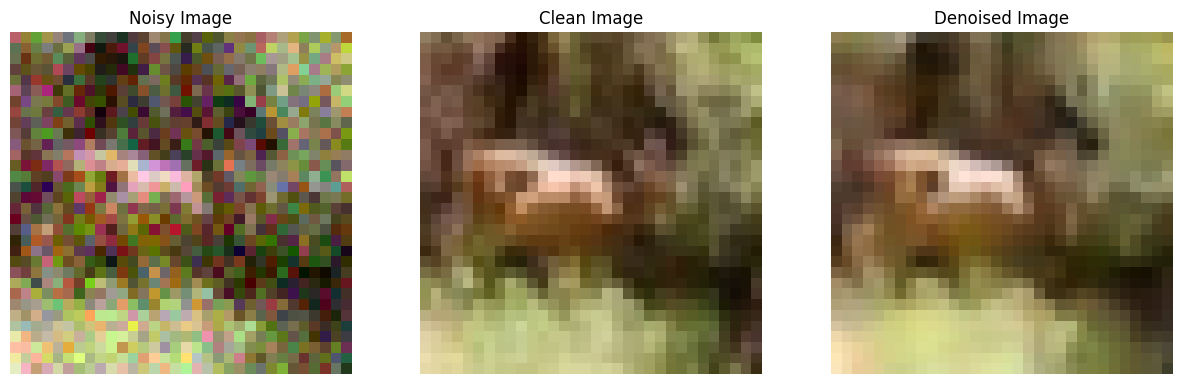

In [6]:
# Define the U-Net architecture
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Training function
def train_score_network(model, dataloader, epochs=200, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        for noisy_image, clean_image in dataloader:
            noisy_image, clean_image = noisy_image.cuda(), clean_image.cuda()
            optimizer.zero_grad()
            output = model(noisy_image)

            # Resize the output to match the input dimensions
            output = F.interpolate(output, size=clean_image.shape[2:])

            loss = criterion(output, clean_image)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

# Denoising function
def denoise_image(noisy_image, model):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        noisy_image = noisy_image.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        denoised_image = model(noisy_image)
        denoised_image = F.interpolate(denoised_image, size=noisy_image.shape[2:])
    return denoised_image.cpu()

# Example usage
if __name__ == "__main__":
    # Load the noisy CIFAR-10 training dataset
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    train_dataset = NoisyCIFAR10(root='./data', train=True, download=True, transform=transform, noise_sigma=0.1)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    # Initialize the score network
    model_normal = UNet().cuda()

    # Train the score network
    train_score_network(model_normal, train_loader, epochs=10)

    # Load a noisy image for denoising
    noisy_image, clean_image = next(iter(train_loader))
    noisy_image = noisy_image[0].unsqueeze(0)  # Take the first image in the batch

    # Denoise the image
    denoised_image = denoise_image(noisy_image, model_normal)

    # Plot the images
    plot_images([noisy_image.cpu(), clean_image[0].cpu(), denoised_image.cpu()], ["Noisy Image", "Clean Image", "Denoised Image"])

MSE Loss: 0.1543189287185669


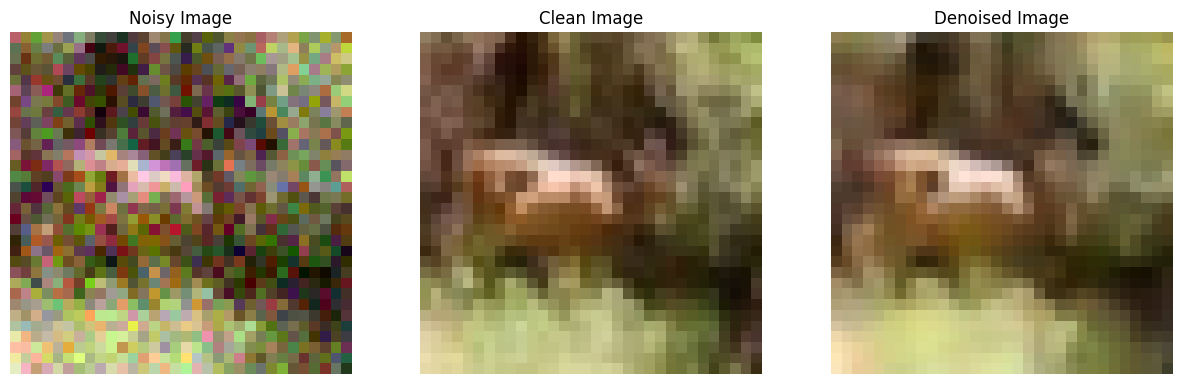

In [7]:
noisy_image_test, clean_image_test = next(iter(train_loader))

denoised_image_test = denoise_image(noisy_image, model_normal)


denoised_image_np = denoised_image_test.cpu().numpy()
clean_image_np = clean_image_test[0].unsqueeze(0).cpu().numpy()


# Calculate MSE using NumPy
mse_loss = np.mean((denoised_image_np - clean_image_np) ** 2)

# Print the MSE loss
print(f"MSE Loss: {mse_loss}")

plot_images([noisy_image.cpu(), clean_image[0].cpu(), denoised_image.cpu()], ["Noisy Image", "Clean Image", "Denoised Image"])

Epoch 1/50, Loss: 0.004971641581505537
Epoch 2/50, Loss: 0.0023230598308146
Epoch 3/50, Loss: 0.002224894007667899
Epoch 4/50, Loss: 0.0022470164112746716
Epoch 5/50, Loss: 0.002360075246542692
Epoch 6/50, Loss: 0.002169782994315028
Epoch 7/50, Loss: 0.0022511279676109552
Epoch 8/50, Loss: 0.002104349434375763
Epoch 9/50, Loss: 0.0021108281798660755
Epoch 10/50, Loss: 0.002118166070431471
Epoch 11/50, Loss: 0.0020078327506780624
Epoch 12/50, Loss: 0.00200272211804986
Epoch 13/50, Loss: 0.0019760129507631063
Epoch 14/50, Loss: 0.0019772907253354788
Epoch 15/50, Loss: 0.0019717959221452475
Epoch 16/50, Loss: 0.0018249028362333775
Epoch 17/50, Loss: 0.001872085384093225
Epoch 18/50, Loss: 0.0018633329309523106
Epoch 19/50, Loss: 0.001802279381081462
Epoch 20/50, Loss: 0.0018622825155034661
Epoch 21/50, Loss: 0.0018963071051985025
Epoch 22/50, Loss: 0.001803278923034668
Epoch 23/50, Loss: 0.0017615406541153789
Epoch 24/50, Loss: 0.0018797214142978191
Epoch 25/50, Loss: 0.001726382062770426

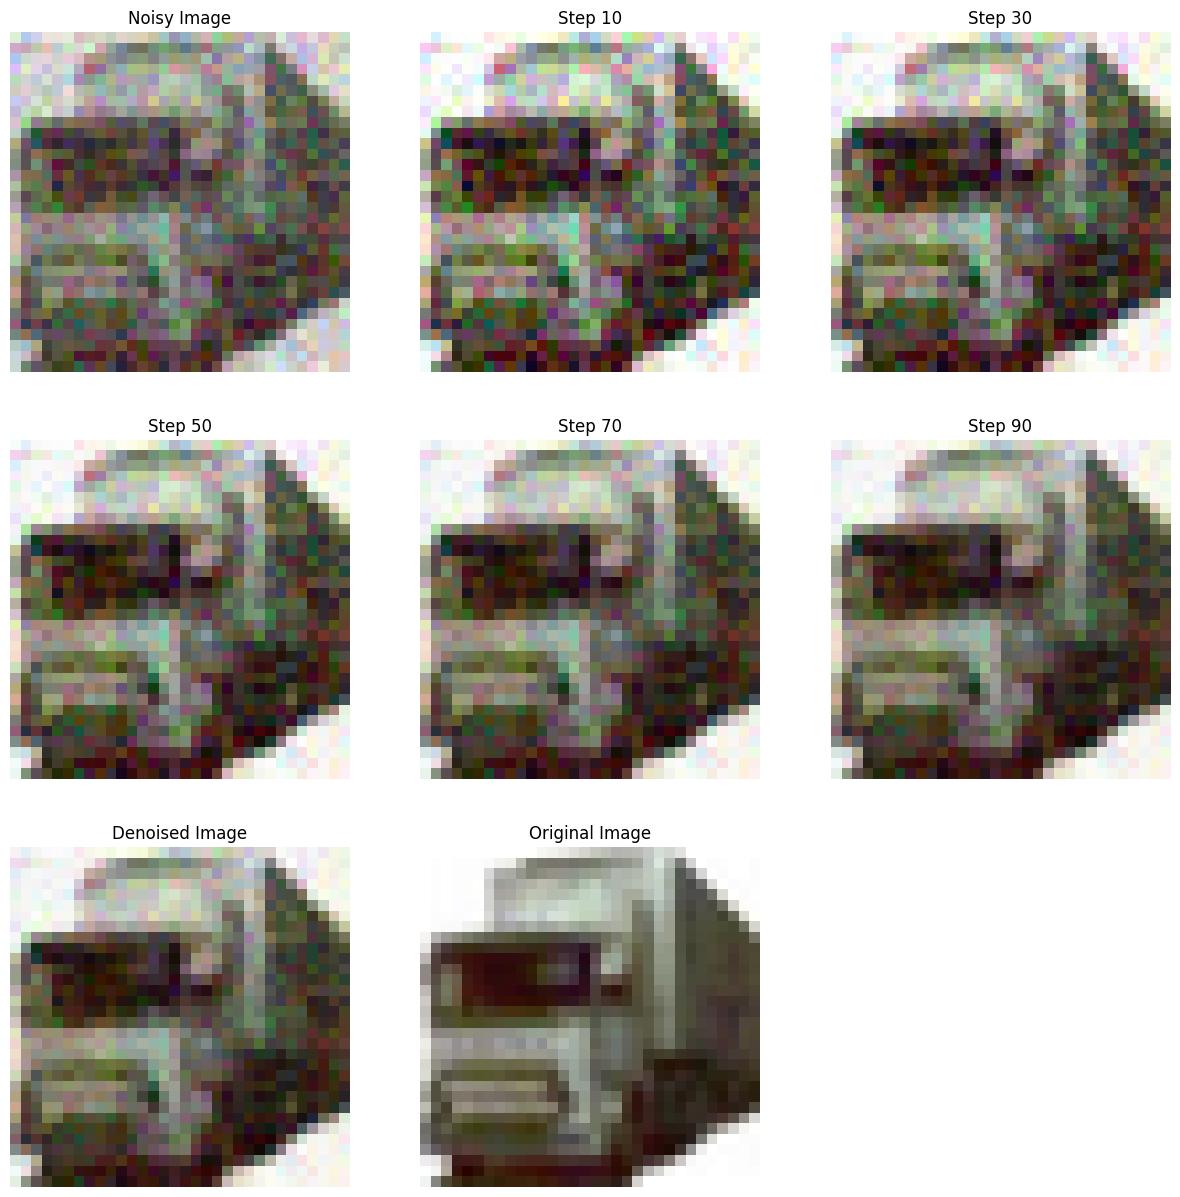

In [8]:
# Define the Score Network
class ScoreNetwork(nn.Module):
    def __init__(self):
        super(ScoreNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 3, kernel_size=3, padding=1)
        )

    def forward(self, x):
        return self.net(x)

# Training function for the Score Network
def train_score_network(model, dataloader, epochs=200, lr=0.0001, noise_sigma=0.1):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        for clean_image, _ in dataloader:
            clean_image = clean_image.cuda()
            noise = torch.randn_like(clean_image) * noise_sigma
            noisy_image = clean_image + noise

            optimizer.zero_grad()
            score = model(noisy_image)
            loss = criterion(score * noise_sigma**2 + noisy_image, clean_image)
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

# Denoising function using Langevin dynamics with intermediate steps
def denoise_image_score_based(noisy_image, model, noise_sigma=0.1, num_steps=100, step_size=0.001, intermediate_steps=None):
    model.eval()
    with torch.no_grad():
        x = noisy_image.clone()
        intermediate_images = []
        for step in range(num_steps):
            noise = torch.randn_like(x) * noise_sigma
            score = model(x)
            x = x + step_size * score + noise * (2 * step_size)**0.5
            x = torch.clamp(x, 0, 1)  # Ensure the image stays in the range [0, 1]

            # Store intermediate images if specified
            if intermediate_steps and step in intermediate_steps:
                intermediate_images.append(x.clone().cpu())

        return x, intermediate_images

# Example usage
if __name__ == "__main__":
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

    model = ScoreNetwork().cuda()
    train_score_network(model, train_loader, epochs=50)

    original_image, _ = next(iter(train_loader))
    original_image = original_image[0].unsqueeze(0).cuda()
    noisy_image = original_image + torch.randn_like(original_image) * 0.1

    # Specify intermediate steps to visualize
    intermediate_steps = [10, 30, 50, 70, 90]
    denoised_image, intermediate_images = denoise_image_score_based(noisy_image, model, step_size=0.0001, intermediate_steps=intermediate_steps)

    # Calculate MSE
    # mse_value = calculate_mse(denoised_image, original_image)
    # print(f"MSE between denoised and original image: {mse_value}")

    # Plot the images
    images_to_plot = [noisy_image.cpu()] + intermediate_images + [denoised_image.cpu()] + [original_image.cpu()]
    titles = ["Noisy Image"] + [f"Step {step}" for step in intermediate_steps] + ["Denoised Image"] + ["Original Image"]
    plot_images(images_to_plot, titles)


In [9]:
# Function to calculate MSE
def calculate_mse(image1, image2):
    return F.mse_loss(image1, image2).item()

# Function to calculate PSNR
def calculate_psnr(image1, image2, max_value=1.0):
    mse = calculate_mse(image1, image2)
    if mse == 0:
        return float('inf')
    return 20 * torch.log10(max_value / torch.sqrt(torch.tensor(mse)))

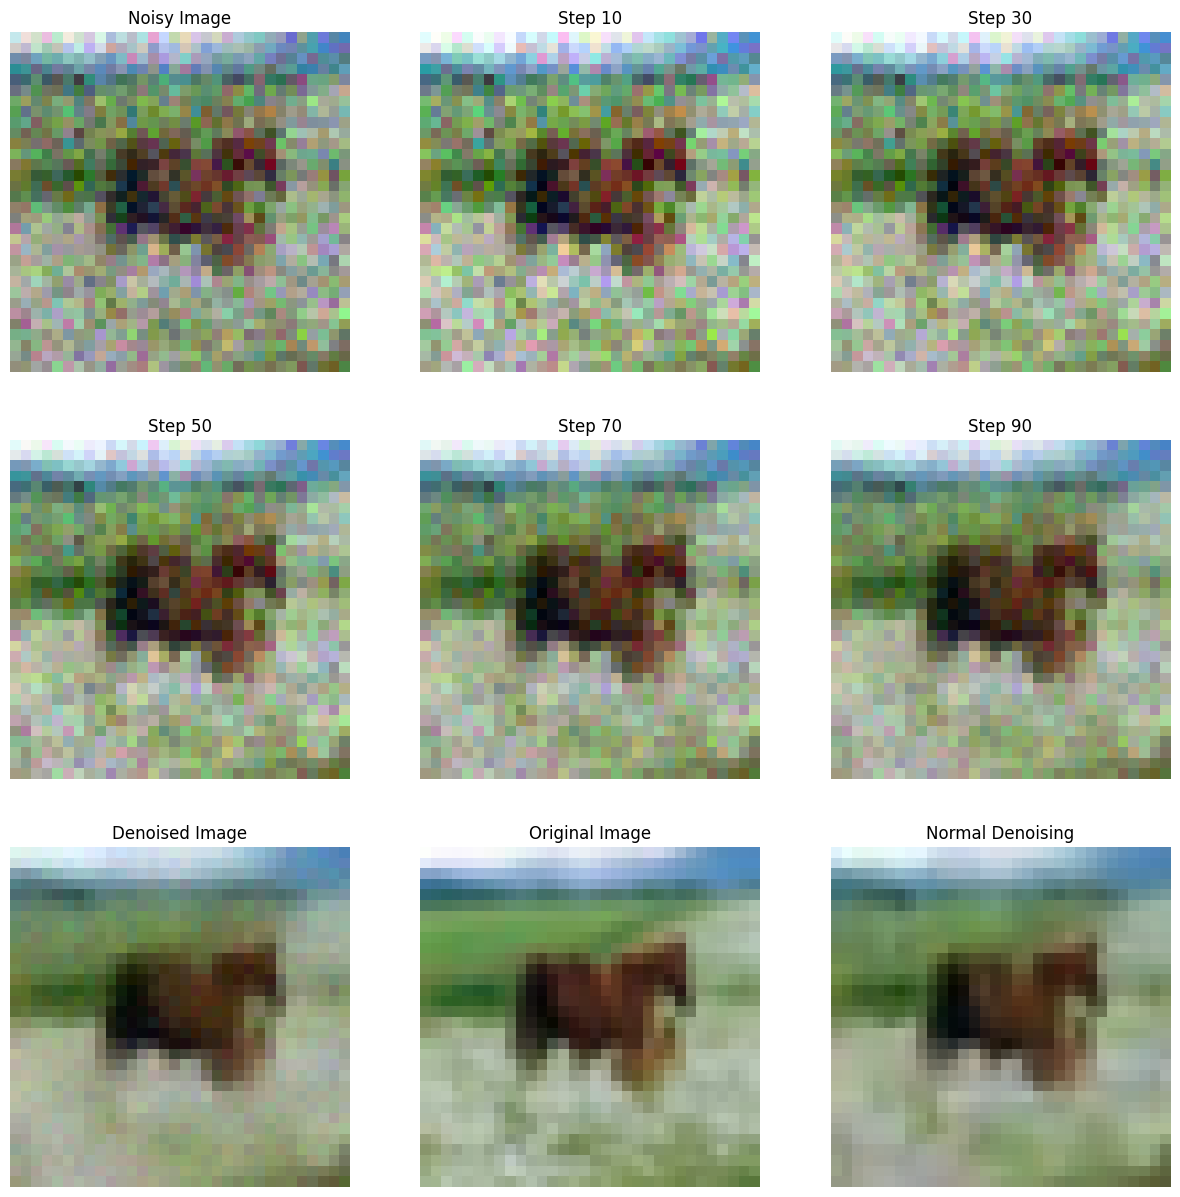

MSE between denoised and original image: 0.0020690776873379946
PSNR between denoised and original image: 26.84223175048828 dB
MSE between normal denoised and original image: 0.0014475019415840507
PSNR between normal denoised and original image: 28.39380645751953 dB


In [16]:
# original_image, _ = next(iter(train_loader))
# original_image = original_image[0].unsqueeze(0).cuda()
noisy_image = original_image + torch.randn_like(original_image) * 0.1

# Specify intermediate steps to visualize
intermediate_steps = [10, 30, 50, 70, 90]
denoised_image, intermediate_images = denoise_image_score_based(noisy_image, model, num_steps=200, step_size=0.0001, intermediate_steps=intermediate_steps)

# Calculate MSE
# mse_value = calculate_mse(denoised_image, original_image)
# print(f"MSE between denoised and original image: {mse_value}")

denoised_image_test = denoise_image(noisy_image, model_normal)

# Plot the images
images_to_plot = [noisy_image.cpu()] + intermediate_images + [denoised_image.cpu()] + [original_image.cpu()] + [denoised_image_test.cpu()]
titles = ["Noisy Image"] + [f"Step {step}" for step in intermediate_steps] + ["Denoised Image"] + ["Original Image"] + ["Normal Denoising"]
plot_images(images_to_plot, titles)

denoised_image = denoised_image.to(original_image.device)
denoised_image_test = denoised_image_test.to(original_image.device)

# Calculate MSE and PSNR for the denoised image
mse_denoised = calculate_mse(denoised_image, original_image)
psnr_denoised = calculate_psnr(denoised_image, original_image)

# Calculate MSE and PSNR for the normal denoised image
mse_denoised_test = calculate_mse(denoised_image_test, original_image)
psnr_denoised_test = calculate_psnr(denoised_image_test, original_image)

print(f"MSE between denoised and original image: {mse_denoised}")
print(f"PSNR between denoised and original image: {psnr_denoised.item()} dB")

print(f"MSE between normal denoised and original image: {mse_denoised_test}")
print(f"PSNR between normal denoised and original image: {psnr_denoised_test.item()} dB")


In [15]:
# Check if the denoised images are identical
are_identical = torch.allclose(denoised_image, denoised_image_test)
print(f"The denoised images are identical: {are_identical}")

The denoised images are identical: True


## Impact of the step size

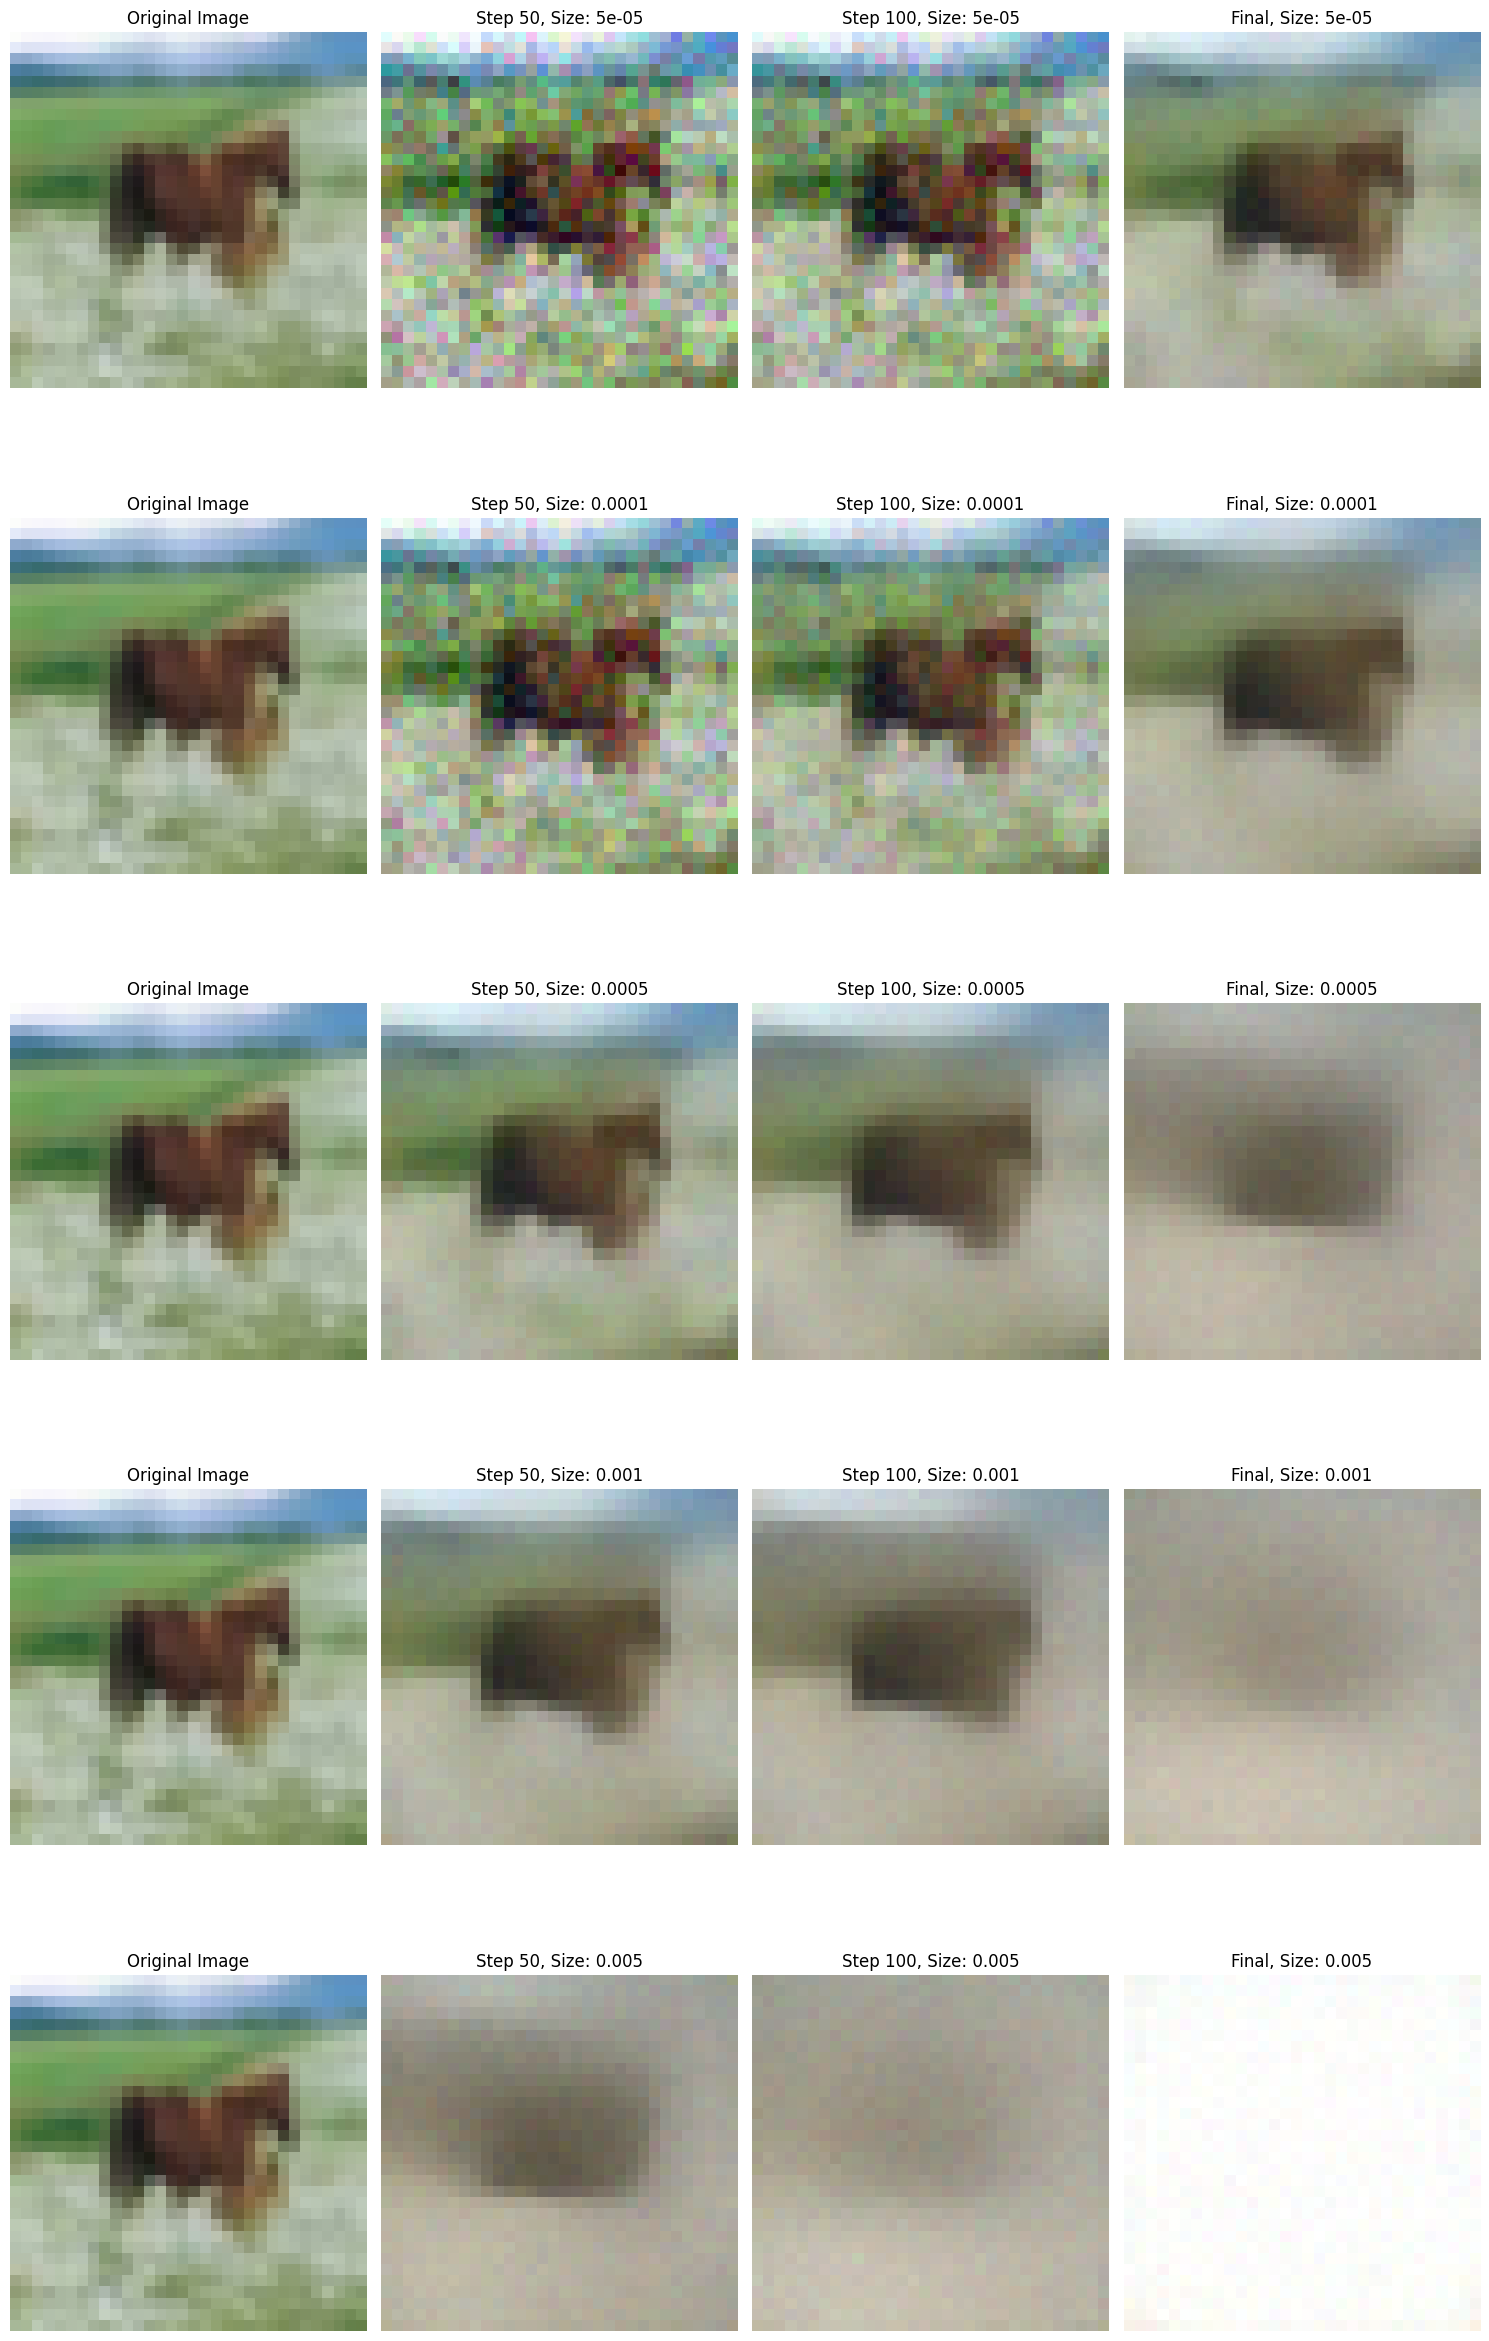

In [20]:
import matplotlib.pyplot as plt

# Define a list of step sizes to test
step_sizes = [0.00005, 0.0001, 0.0005, 0.001, 0.005]

# Define intermediate steps to visualize
intermediate_steps = [50, 100]

# Store the denoised images and intermediate steps for each step size
denoised_images = []
intermediate_images_list = []

# Perform denoising for each step size
for step_size in step_sizes:
    denoised_image, intermediate_images = denoise_image_score_based(
        noisy_image, model, num_steps=500, step_size=step_size, intermediate_steps=intermediate_steps
    )
    denoised_images.append(denoised_image.cpu())
    intermediate_images_list.append(intermediate_images)

# Plot the images
def plot_images_with_step_sizes(denoised_images, intermediate_images_list, step_sizes, original_image):
    num_step_sizes = len(step_sizes)
    num_intermediate = len(intermediate_steps)
    fig, axes = plt.subplots(num_step_sizes, num_intermediate + 2, figsize=(15, 5 * num_step_sizes))

    # Plot the original image in the first column
    for i in range(num_step_sizes):
        axes[i, 0].imshow(original_image.cpu().squeeze().permute(1, 2, 0))
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis('off')

    # Plot the intermediate and final denoised images
    for i, step_size in enumerate(step_sizes):
        axes[i, 1].imshow(intermediate_images_list[i][0].squeeze().permute(1, 2, 0))
        axes[i, 1].set_title(f"Step {intermediate_steps[0]}, Size: {step_size}")
        axes[i, 1].axis('off')

        axes[i, 2].imshow(intermediate_images_list[i][1].squeeze().permute(1, 2, 0))
        axes[i, 2].set_title(f"Step {intermediate_steps[1]}, Size: {step_size}")
        axes[i, 2].axis('off')

        axes[i, 3].imshow(denoised_images[i].squeeze().permute(1, 2, 0))
        axes[i, 3].set_title(f"Final, Size: {step_size}")
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()

# Plot the denoised images with different step sizes and intermediate steps
plot_images_with_step_sizes(denoised_images, intermediate_images_list, step_sizes, original_image)


## Evolution with the number of steps

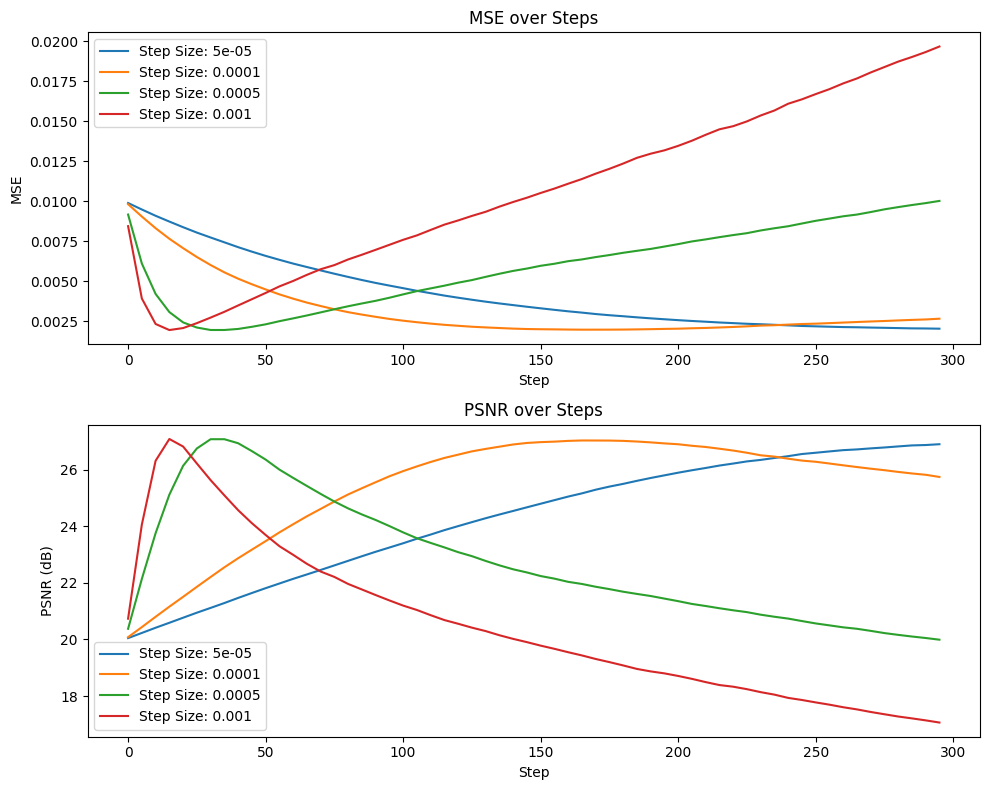

In [33]:
# Define a list of step sizes to test
step_sizes = [0.00005, 0.0001, 0.0005, 0.001]
num_steps = 300

# Define the interval for calculating MSE and PSNR
calculation_interval = 5

# Store the MSE and PSNR values for each step size
mse_values = {step_size: [] for step_size in step_sizes}
psnr_values = {step_size: [] for step_size in step_sizes}

# Perform denoising for each step size and calculate MSE and PSNR
for step_size in step_sizes:
    model.eval()
    with torch.no_grad():
        x = noisy_image.clone()
        for step in range(num_steps):
            noise = torch.randn_like(x) * 0.1
            score = model(x)
            x = x + step_size * score + noise * (2 * step_size)**0.5
            x = torch.clamp(x, 0, 1)

            # Calculate MSE and PSNR every 5 steps
            if step % calculation_interval == 0:
                mse = calculate_mse(x, original_image)
                psnr = calculate_psnr(x, original_image)
                mse_values[step_size].append(mse)
                psnr_values[step_size].append(psnr.item())

# Plot the MSE and PSNR values
def plot_metrics(mse_values, psnr_values, step_sizes, calculation_interval):
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))

    # Plot MSE
    for step_size in step_sizes:
        axes[0].plot(range(0, num_steps, calculation_interval), mse_values[step_size], label=f'Step Size: {step_size}')
    axes[0].set_title('MSE over Steps')
    axes[0].set_xlabel('Step')
    axes[0].set_ylabel('MSE')
    axes[0].legend()

    # Plot PSNR
    for step_size in step_sizes:
        axes[1].plot(range(0, num_steps, calculation_interval), psnr_values[step_size], label=f'Step Size: {step_size}')
    axes[1].set_title('PSNR over Steps')
    axes[1].set_xlabel('Step')
    axes[1].set_ylabel('PSNR (dB)')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

# Plot the MSE and PSNR results
plot_metrics(mse_values, psnr_values, step_sizes, calculation_interval)


Make a gif

In [30]:
import torch
import imageio
import matplotlib.pyplot as plt

# Define the step size and number of steps for the denoising process
step_size = 0.0001
num_steps = 200

# Perform denoising and store intermediate images
model.eval()
with torch.no_grad():
    x = noisy_image.clone()
    intermediate_images = [x.clone().cpu()]  # Start with the noisy image
    for step in range(num_steps):
        noise = torch.randn_like(x) * 0.1
        score = model(x)
        x = x + step_size * score + noise * (2 * step_size)**0.5
        x = torch.clamp(x, 0, 1)

        # Store intermediate images
        if step % 5 == 0:  # Store every 5 steps
            intermediate_images.append(x.clone().cpu())

# Append the final denoised image
intermediate_images.append(x.clone().cpu())

# Save each intermediate image as a file
image_files = []
for i, image in enumerate(intermediate_images):
    plt.imshow(image.squeeze().permute(1, 2, 0))
    plt.axis('off')
    file_name = f'step_{i}.png'
    plt.savefig(file_name, bbox_inches='tight', pad_inches=0)
    image_files.append(file_name)
    plt.close()

# Create a GIF from the saved images
gif_path = 'denoising_process.gif'
with imageio.get_writer(gif_path, mode='I', duration=0.2) as writer:
    for file_name in image_files:
        image = imageio.imread(file_name)
        writer.append_data(image)

print(f"GIF created and saved as {gif_path}")


<ipython-input-30-7dc812f714cd>:41: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(file_name)


GIF created and saved as denoising_process.gif
